In [1]:
from pathlib import Path
import yaml
import pandas as pd

from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier
from catboost import EFeaturesSelectionAlgorithm, EShapCalcType
from catboost import Pool

## Constants

In [2]:
RANDOM_SEED = 77
N_JOBS = 7
DATA_PATH = Path("../../data/")

## Data

In [3]:
df_train = pd.read_parquet(DATA_PATH / "train_preproc.parquet")

ohe_cols = df_train.columns[df_train.columns.str.startswith("OneHotEncoder")].values.tolist()
oe_cols = df_train.columns[df_train.columns.str.startswith("OrdinalEncoder")].values.tolist()
te_cols = df_train.columns[df_train.columns.str.startswith("MeanTargetEncoder")].values.tolist()
num_cols = df_train.columns[df_train.columns.str.startswith("numeric")].values.tolist()

In [4]:
X_train, y_train = df_train.drop(columns=["id", "target", "smpl"] + te_cols), df_train["target"]

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.3, random_state=RANDOM_SEED)

## Model

In [6]:
train_pool = Pool(X_train, y_train, cat_features=oe_cols + ohe_cols)
val_pool = Pool(X_val, y_val, cat_features=oe_cols + ohe_cols)

In [12]:
model = CatBoostClassifier(random_state=RANDOM_SEED, verbose=0, early_stopping_rounds=200, iterations=2500,
                           thread_count=N_JOBS, allow_writing_files=False)

summary = model.select_features(train_pool, eval_set=val_pool,
                                features_for_select=num_cols,
                                num_features_to_select=50,
                                verbose=False,
                                algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
                                shap_calc_type=EShapCalcType.Regular, steps=10)

Learning rate set to 0.086245
Step #1 out of 10
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.189491792
bestIteration = 228

Shrink model to first 229 iterations.
Feature #155 eliminated
Feature #37 eliminated
Feature #93 eliminated
Feature #105 eliminated
Feature #73 eliminated
Feature #162 eliminated
Feature #53 eliminated
Feature #74 eliminated
Feature #115 eliminated
Feature #41 eliminated
Feature #152 eliminated
Feature #30 eliminated
Feature #60 eliminated
Feature #63 eliminated
Feature #114 eliminated
Step #2 out of 10
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.1890863225
bestIteration = 396

Shrink model to first 397 iterations.
Feature #150 eliminated
Feature #119 eliminated
Feature #88 eliminated
Feature #113 eliminated
Feature #47 eliminated
Feature #112 eliminated
Feature #117 eliminated
Feature #20 eliminated
Feature #33 eliminated
Feature #147 eliminated
Feature #44 eliminated
Feature #84 eliminated
Feature #137 eliminated


In [13]:
with open("../../configs/config.yaml", "a") as f:
    yaml.dump({"selected_features": summary["selected_features_names"]}, f)

In [7]:
with open("../../configs/config.yaml", "r") as f:
    cfg = yaml.load(f, Loader=yaml.SafeLoader)

In [9]:
train_pool = Pool(X_train[cfg["selected_features"] + oe_cols + ohe_cols], y_train, cat_features=oe_cols + ohe_cols)
val_pool = Pool(X_val[cfg["selected_features"] + oe_cols + ohe_cols], y_val, cat_features=oe_cols + ohe_cols)

In [12]:
model = CatBoostClassifier(random_state=RANDOM_SEED, verbose=1, early_stopping_rounds=200, iterations=2500,
                           thread_count=N_JOBS, allow_writing_files=False)

In [34]:
model.fit(X_train[cfg["selected_features"] + oe_cols + ohe_cols], y_train,
          eval_set=(X_val[cfg["selected_features"] + oe_cols + ohe_cols], y_val), cat_features=oe_cols + ohe_cols)

Learning rate set to 0.086245
0:	learn: 0.5819188	test: 0.5817452	best: 0.5817452 (0)	total: 155ms	remaining: 6m 27s
1:	learn: 0.4928625	test: 0.4924682	best: 0.4924682 (1)	total: 325ms	remaining: 6m 45s
2:	learn: 0.4245521	test: 0.4240758	best: 0.4240758 (2)	total: 448ms	remaining: 6m 13s
3:	learn: 0.3748791	test: 0.3744159	best: 0.3744159 (3)	total: 571ms	remaining: 5m 56s
4:	learn: 0.3374910	test: 0.3370193	best: 0.3370193 (4)	total: 697ms	remaining: 5m 47s
5:	learn: 0.3075162	test: 0.3070282	best: 0.3070282 (5)	total: 817ms	remaining: 5m 39s
6:	learn: 0.2845249	test: 0.2840978	best: 0.2840978 (6)	total: 925ms	remaining: 5m 29s
7:	learn: 0.2659059	test: 0.2654737	best: 0.2654737 (7)	total: 1.07s	remaining: 5m 34s
8:	learn: 0.2514345	test: 0.2509869	best: 0.2509869 (8)	total: 1.2s	remaining: 5m 31s
9:	learn: 0.2408772	test: 0.2404747	best: 0.2404747 (9)	total: 1.36s	remaining: 5m 38s
10:	learn: 0.2321415	test: 0.2317631	best: 0.2317631 (10)	total: 1.49s	remaining: 5m 36s
11:	learn: 0

In [37]:
import shap

In [38]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_val[cfg["selected_features"] + oe_cols + ohe_cols])

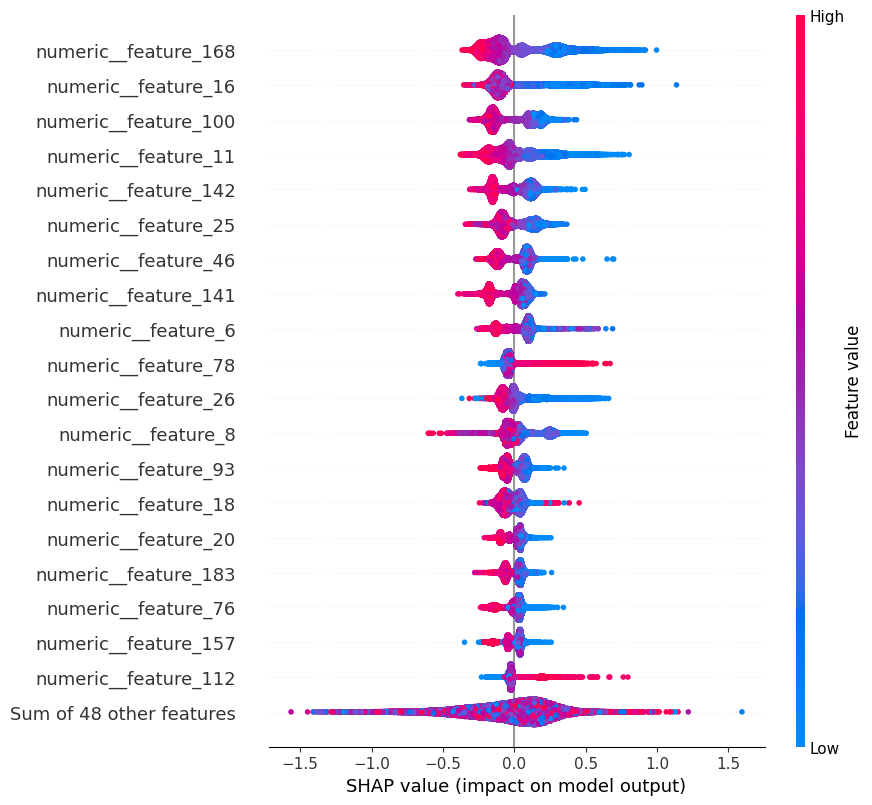

In [43]:
shap.plots.beeswarm(shap_values, max_display=20)

In [49]:
df_train.drop(columns="smpl").corr()["target"].sort_values()

numeric__feature_16              -0.214209
numeric__feature_11              -0.208062
numeric__feature_143             -0.170355
numeric__feature_142             -0.156228
numeric__feature_95              -0.154141
                                    ...   
MeanTargetEncoder__feature_60     0.063092
OrdinalEncoder__feature_179       0.134955
OneHotEncoder__feature_71_2       0.137764
MeanTargetEncoder__feature_179    0.138641
target                            1.000000
Name: target, Length: 175, dtype: float64

<Axes: xlabel='id', ylabel='numeric__feature_95'>

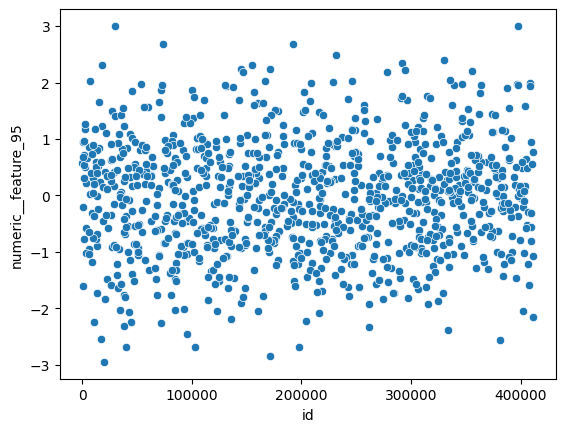

In [15]:
import seaborn as sns
sns.scatterplot(df_train[["numeric__feature_95", "id"]].sample(1000), x="id", y="numeric__feature_95")